In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from pathlib import Path
from IPython.display import display, HTML
from scipy.stats import rankdata
from Orange.evaluation import compute_CD, graph_ranks

sns.set_style("ticks", {
    'axes.grid': True,
    'grid.color': '.5'})
sns.set_context("paper")
# sns.set_palette("crest")
# sns.color_palette("muted")
# sns.color_palette("crest", as_cmap=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
Path("results_plots/").mkdir(parents=True, exist_ok=True)

In [2]:
EVALMETRIC = 'roc_auc'

In [3]:
df = pd.read_csv("results_df/fv_selection_exp.csv", index_col=0)
df.head(3)

,dataset,fs_method,eval_algorithm,parameters,po_features,n_features,accuracy_val,balanced_accuracy_val,roc_auc_val,average_precision_val,precision_val,recall_val,f1_val,accuracy_test,balanced_accuracy_test,roc_auc_test,average_precision_test,precision_test,recall_test,f1_test
0,read_german_data,hypper_weights,LogisticRegression,"{'feature_values': True, 'method': 'hypper_weights', 'weighting_iterations': 1, 'weighting_normalization_strategy': 'max'}",0.3,222,0.688623,0.666071,0.726867,0.788462,0.838784,0.732143,0.759259,0.712575,0.648998,0.718397,0.813559,0.859453,0.786885,0.800000
1,read_german_data,hypper_weights,MLPClassifier,"{'feature_values': True, 'method': 'hypper_weights', 'weighting_iterations': 1, 'weighting_normalization_strategy': 'max'}",0.3,222,0.658683,0.514205,0.649432,0.677419,0.770356,0.937500,0.786517,0.742515,0.550273,0.667577,0.751592,0.837730,0.967213,0.845878
2,read_german_data,hypper_weights,CatBoostClassifier,"{'feature_values': True, 'method': 'hypper_weights', 'weighting_iterations': 1, 'weighting_normalization_strategy': 'max'}",0.3,222,0.718563,0.609740,0.788880,0.727273,0.854607,0.928571,0.815686,0.790419,0.646175,0.732787,0.795918,0.860723,0.959016,0.869888


In [4]:
print(f"FS methods: {df['fs_method'].unique().tolist()}")
print(f"Datasets: {df['dataset'].unique().tolist()}")
print(f"Evaluation models: {df['eval_algorithm'].unique().tolist()}")
# print(f"Parameters sets: {df['parameters'].unique().tolist()}")

FS methods: ['hypper_weights', 'hypper_rw', 'random_forest', 'logistic_regression', 'random']
Datasets: ['read_german_data', 'read_spect_heart', 'read_breast_cancer_data', 'read_congressional_voting_records', 'read_phishing', 'read_hr']
Evaluation models: ['LogisticRegression', 'MLPClassifier', 'CatBoostClassifier', 'LGBMClassifier']


In [5]:
# Select best hypper params validation data
tuned_methods = ['hypper_weights', 'hypper_rw']
grouping_key = ['fs_method','dataset','eval_algorithm','po_features','parameters']
df_test = df[df.fs_method.isin(tuned_methods)]

df_test = df_test.groupby(grouping_key).mean()
metric = [EVALMETRIC+'_val', EVALMETRIC+'_test']
df_test = df_test[metric].sort_values(by=EVALMETRIC+'_val', ascending=False)
df_test = df_test.groupby(grouping_key[:-1]).head(1).reset_index().set_index(grouping_key).sort_index()
best_params = list(df_test.index)
print(len(best_params))
best_params[:2]

96


[('hypper_rw',
  'read_breast_cancer_data',
  'CatBoostClassifier',
  0.3,
  "{'feature_values': True, 'iterations': 10000, 'method': 'hypper_rw', 'scoring_variant': 'v1_3', 'walk_length': 3}"),
 ('hypper_rw',
  'read_breast_cancer_data',
  'CatBoostClassifier',
  0.5,
  "{'feature_values': True, 'iterations': 10000, 'method': 'hypper_rw', 'scoring_variant': 'v1_3', 'walk_length': 3}")]

In [6]:
print(df.shape)
df_best = deepcopy(df)
df_best = df_best.set_index(grouping_key)
df_best = df_best[
    (~df_best.index.isin(tuned_methods, level='fs_method')) |
    (df_best.index.isin(best_params))
].sort_index().reset_index()
df_best.shape

(2304, 20)


(720, 20)

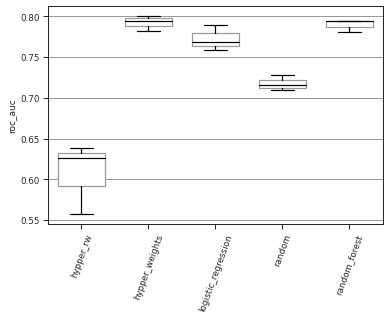

In [7]:
DATASET = 'read_hr'
EVALALG = 'CatBoostClassifier'
PO_FEATURES = 0.3

df_plot = df_best[df_best.dataset == DATASET]
df_plot = df_plot[df_plot.eval_algorithm == EVALALG]
df_plot = df_plot[df_plot.po_features == PO_FEATURES]

f, ax = plt.subplots(1, 1)
sns.boxplot(data=df_plot, x='fs_method', y=EVALMETRIC+'_test', ax=ax, color='white', width=.7, fliersize=3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
plt.xticks(rotation=70)
ax.set_ylabel(EVALMETRIC, fontsize=9)
ax.set_xlabel(None, fontsize=6, weight='bold')
# ax.set_xticklabels(['Without\nundersampling', 'Hypper', 'Tomek\nLinks', 'Random', 'ENN', 'Near-Miss'])
f.savefig(f'results_plots/fs_criteo_{EVALMETRIC}.pdf')
plt.show()

FS methods: ['hypper_rw', 'hypper_weights', 'logistic_regression', 'random', 'random_forest']
Shape: (90, 20)
hypper_rw average rank: 4.361111111111111
hypper_weights average rank: 2.0277777777777777
logistic_regression average rank: 2.4444444444444446
random average rank: 4.444444444444445
random_forest average rank: 1.7222222222222223


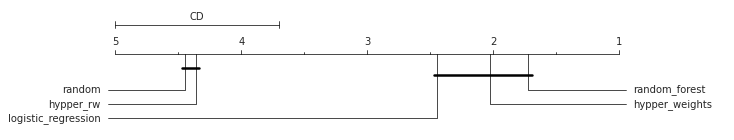

In [8]:
# Friedman test - https://edisciplinas.usp.br/pluginfile.php/4129451/mod_resource/content/1/model_selection_evaluation.pdf
df_eval_metric = df_best[(df_best.eval_algorithm == EVALALG) & (df_best.po_features == PO_FEATURES)].set_index(grouping_key).sort_index().reset_index()
fs_methods = df_eval_metric['fs_method'].unique().tolist()
datasets = df_eval_metric['dataset'].unique().tolist()
kfolds = 3
print(f"FS methods: {fs_methods}")
print(f"Shape: {df_eval_metric.shape}")

df_eval_metric['experiment_num'] = pd.Series(list(range(1,kfolds+1))*len(fs_methods)*len(datasets))

# display(df_eval_metric[grouping_key+['experiment_num']+[EVALMETRIC+'_test']].head(50))

performance_array = df_eval_metric.groupby(['dataset', 'experiment_num'])[EVALMETRIC+'_test'].apply(np.array)
# performance_array
ranks = np.array([rankdata(-p) for p in performance_array])
# print(ranks[:5])
average_ranks = np.mean(ranks, axis=0)
# print(average_ranks)
print('\n'.join('{} average rank: {}'.format(a, r) for a, r in zip(fs_methods, average_ranks)))

cd = compute_CD(average_ranks,
                n=len(datasets)*kfolds,
                alpha='0.1',
                test='nemenyi')
# This method generates the plot.
graph_ranks(average_ranks,
            names=fs_methods,
            cd=cd,
            width=10,
            textspace=1.5,
            reverse=True)
plt.savefig('results_plots/fs_friedman.pdf')
plt.show()